Import and Download

In [ ]:
# Install necessary libraries
!pip install nltk torch torchvision torchaudio transformers

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, Dataset

In [ ]:
!kaggle datasets download -d atulanandjha/imdb-50k-movie-reviews-test-your-bert

import zipfile

with zipfile.ZipFile('imdb-50k-movie-reviews-test-your-bert.zip', 'r') as zip_ref:
    zip_ref.extractall("/content")

Dataset URL: https://www.kaggle.com/datasets/atulanandjha/imdb-50k-movie-reviews-test-your-bert
License(s): GNU Lesser General Public License 3.0
imdb-50k-movie-reviews-test-your-bert.zip: Skipping, found more recently modified local copy (use --force to force download)


Dataset and Preprocess

In [ ]:
# Load the data into pandas DataFrame
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

# Ensure sentiment column is numeric: Convert 'pos' to 1, 'neg' to 0
train_df['sentiment'] = train_df['sentiment'].map({'pos': 1, 'neg': 0})
test_df['sentiment'] = test_df['sentiment'].map({'pos': 1, 'neg': 0})

train_df.head()

,text,sentiment
0,"Now, I won't deny that when I purchased this o...",0
1,"The saddest thing about this ""tribute"" is that...",0
2,Last night I decided to watch the prequel or s...,0
3,I have to admit that i liked the first half of...,0
4,I was not impressed about this film especially...,0


In [ ]:
# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,text,sentiment
6868,A woman (Sylvia Kristel) seduces a 15 year old...,0
24016,Passing stones definitely one of the best come...,1
9668,The concept for Sarafina appears to be a sound...,0
13640,"The original ""Cube"" is a fantastic B-movie ric...",0
14018,So...we get so see added footage of Brando...i...,0


In [ ]:
# How many examples of each class?
train_df.sentiment.value_counts()

,count
sentiment,
0,12500
1,12500


In [ ]:
# How many samples total?
print(f"Total training samples: {len(train_df)}")
print(f"Total test samples: {len(test_df)}")
print(f"Total samples: {len(train_df) + len(test_df)}")

Total training samples: 25000
Total test samples: 25000
Total samples: 50000


In [ ]:
# Let's visualize some random training examples
import random
random_index = random.randint(0, len(train_df)-5) # create random indexes not higher than the total number of samples
for row in train_df_shuffled[["text", "sentiment"]][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f"Target: {target}", "(Good Movie)" if target > 0 else "(Bad Movie)")
  print(f"Text:\n{text}\n")
  print("---\n")

Target: 0 (Bad Movie)
Text:
This beautifully filmed and scripted episode was let down for two reasons. 1) Perhaps it was the morality of the 1950s talking, but no man left alone on an asteroid for years would react with such hysterical negativity to the gift of a female android. 2) It wasn't an android at all, but a woman, the beautiful Jean Marsh.<br /><br />The popularity of the sex doll industry in the coming decades could have traced its origins back to this episode if they'd done it properly. In fact, the modernization of sex-bots are in the news as I speak.<br /><br />Robots were not new to movies or television when this episode was made, so they could have at least had her act like one. Her fleshiness would then have added a creepy element. Instead, it becomes a nice little love story about two humans on faraway star.<br /><br />The Twilight Zone always stretched the imagination and credulity. Normally no one cared. But this episode seemed hamstrung by a Calvinist morality esche

In [ ]:
# Preprocessing: Remove special characters, punctuation, and unnecessary whitespace
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = ''.join(e for e in text if e.isalnum() or e.isspace())  # Remove special characters
    return text

# Tokenization, Stopword Removal, and Stemming
def preprocess_data(train_df):
    nltk.download('stopwords')
    stop_words = set(stopwords.words('english'))
    ps = PorterStemmer()

    train_df['processed_text'] = train_df['text'].apply(preprocess_text)
    train_df['processed_text'] = train_df['processed_text'].apply(lambda x: ' '.join([ps.stem(word) for word in x.split() if word not in stop_words]))

    return train_df

train_df = preprocess_data(train_df)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Split the dataset into training and testing sets
X = train_df['processed_text']
y = train_df['sentiment']  # Assuming 'sentiment' column contains labels (positive/negative)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tokenize using BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Feature extraction process.

In [ ]:
def encode_data(texts, tokenizer, max_length=512):
    return tokenizer(texts, padding=True, truncation=True, max_length=max_length, return_tensors='pt')

train_encodings = encode_data(X_train.tolist(), tokenizer)
test_encodings = encode_data(X_test.tolist(), tokenizer)

In [ ]:
# Create a custom dataset class
class IMDBDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels.iloc[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = IMDBDataset(train_encodings, y_train)
test_dataset = IMDBDataset(test_encodings, y_test)

In [ ]:
# DataLoader for batching
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=16, num_workers=2)

# Load BERT model for classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Training setup
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

optimizer = AdamW(model.parameters(), lr=1e-5)
loss_fn = nn.CrossEntropyLoss()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Model training and evaluation.

In [ ]:
# Training the model
def train_model(model, train_loader, optimizer, loss_fn, epochs=3):
    model.train()
    scaler = torch.amp.GradScaler()  # Use torch.amp instead of torch.cuda.amp
    for epoch in range(epochs):
        total_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()

            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass with mixed precision
            with torch.amp.autocast(device_type='cuda'):  # Specify the device type here
                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss

            total_loss += loss.item()

            # Backward pass and optimizer step with gradient scaling
            scaler.scale(loss).backward()  # Use scaler to scale the loss
            scaler.step(optimizer)         # Step optimizer with scaled gradients
            scaler.update()                # Update the scaler for next step

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss}")


Epoch 1/3 - Loss: 0.3455303346633911
Epoch 2/3 - Loss: 0.2268376621246338
Epoch 3/3 - Loss: 0.1384945460319519
Accuracy: 0.8878
Precision: 0.885520542481053
Recall: 0.8901363271852446
F1-Score: 0.8878224355128974


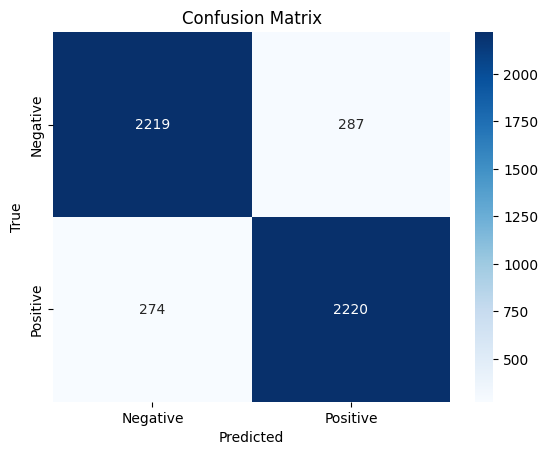

In [ ]:
# Evaluate the model
def evaluate_model(model, test_loader):
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            preds = torch.argmax(logits, dim=1)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions)
    recall = recall_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)

    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-Score: {f1}")

    # Confusion Matrix
    cm = confusion_matrix(true_labels, predictions)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Train and evaluate the model
train_model(model, train_loader, optimizer, loss_fn, epochs=3)
evaluate_model(model, test_loader)

In [ ]:
from transformers import AutoTokenizer
import torch

# Load the tokenizer used during training
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

def predict_sentiment(text, model, device):
    # Preprocess the input text
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    inputs = {key: val.to(device) for key, val in inputs.items()}

    # Put the model in evaluation mode
    model.eval()

    # Make prediction
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        prediction = torch.argmax(logits, dim=1).cpu().numpy()[0]

    # Return the sentiment (0 for negative, 1 for positive)
    return "Positive" if prediction == 1 else "Negative"


Results visualization.

In [ ]:
text = "I love this movie! It was amazing."  # Example text
sentiment = predict_sentiment(text, model, device)
print(f"Sentiment: {sentiment}")


Sentiment: Positive


In [ ]:
texts = [
    "I absolutely hated this movie. It was terrible!",
    "This book is so good, I couldn't put it down.",
    "The food was okay, but the service was bad.",
    "I had an amazing experience. Highly recommend!"
]

for text in texts:
    sentiment = predict_sentiment(text, model, device)
    print(f"Text: {text}\nSentiment: {sentiment}\n")


Text: I absolutely hated this movie. It was terrible!
Sentiment: Negative

Text: This book is so good, I couldn't put it down.
Sentiment: Positive

Text: The food was okay, but the service was bad.
Sentiment: Negative

Text: I had an amazing experience. Highly recommend!
Sentiment: Positive



Not sure if this is highly accurate but it still find capability to comment outside of Movie review whether they are positive or negative view. The model base it on words without proper context as long as it has proper structure which is why it finds it positive as long as the structure is correct like positive plus verb equates to positive comment.